# Forecasting Traffic Using A3T-GCN

In [2]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
#Importing the dataset
import pandas as pd

speeds = pd.read_csv('PeMSD7_Full/PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('PeMSD7_Full/PeMSD7_W_228.csv', names=range(0,228))

Text(0, 0.5, 'Traffic speed')

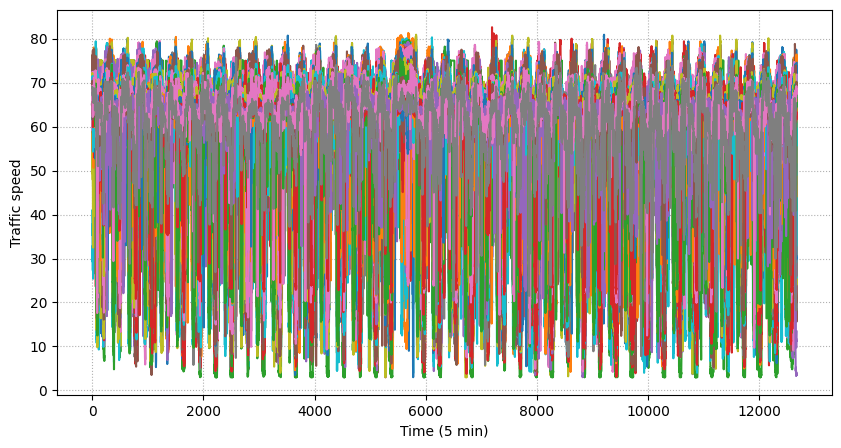

In [6]:
#Visualizing the data
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=100) 
plt.plot(speeds) 
plt.grid(linestyle=':') 
plt.xlabel('Time (5 min)') 
plt.ylabel('Traffic speed')  

Text(0, 0.5, 'Traffic speed')

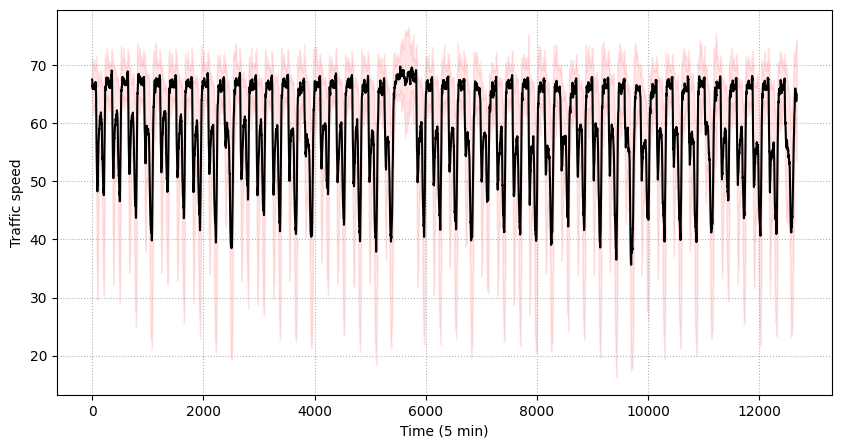

In [7]:
# Plot mean/std traffic speed
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(mean, 'k-')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

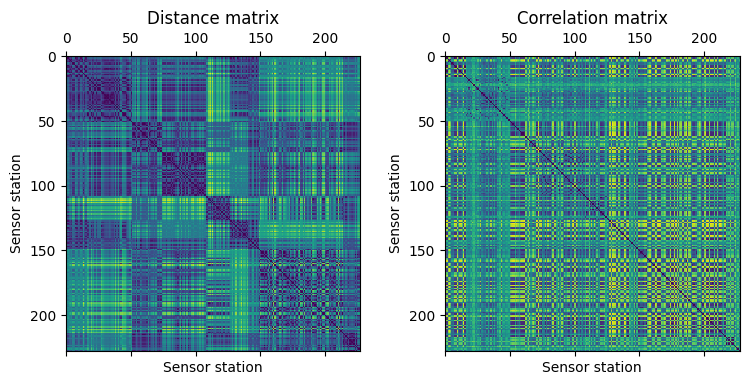

In [8]:
# We can also visualize the correlation between the timeseries in different routes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distances)
ax1.set_xlabel("Sensor station")
ax1.set_ylabel("Sensor station")
ax1.title.set_text("Distance matrix")
ax2.matshow(-np.corrcoef(speeds.T))
ax2.set_xlabel("Sensor station")
ax2.set_ylabel("Sensor station")
ax2.title.set_text("Correlation matrix")

Processing the dataset

In [9]:
#Computing the adjacency matrix with the formula 
def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    d = distances.to_numpy() / 10000.
    d2 = d * d
    n = distances.shape[0]  
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)

Text(0, 0.5, 'Sensor station')

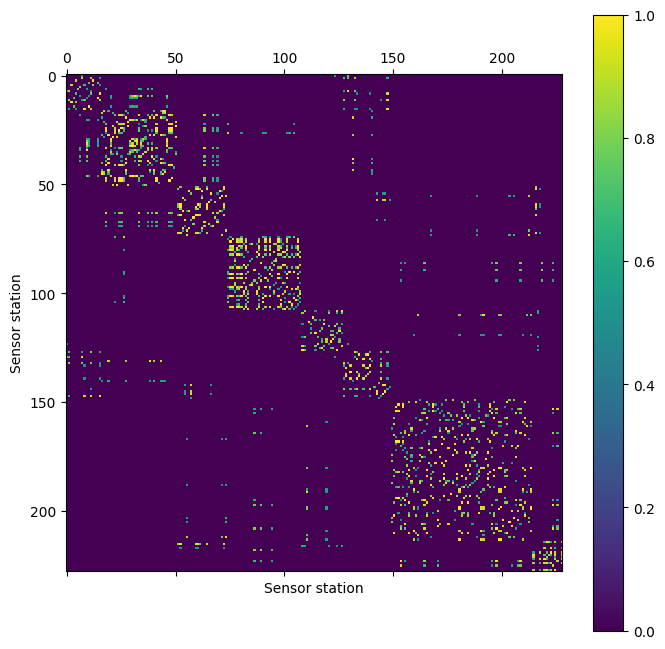

In [10]:
#Plotting it
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

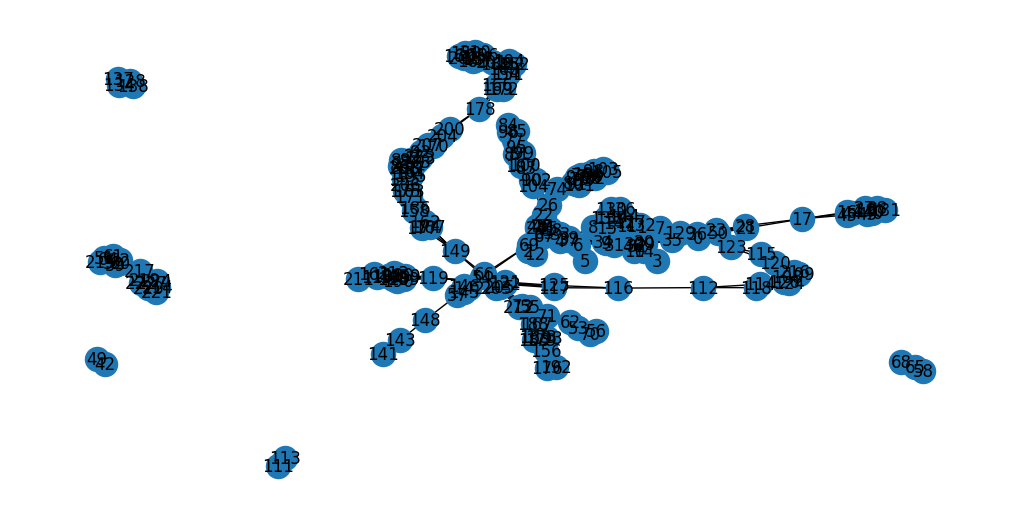

In [11]:
#Visualizing it as a graph
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True)
    plt.show()

plot_graph(adj)

In [12]:
# Apply z-score
def zscore(x, mean, std):
    return (x - mean) / std

speeds_norm = zscore(speeds, speeds.mean(axis=0), speeds.std(axis=0))

# Create dataset
lags = 24
horizon = 48
xs = []
ys = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    xs.append(speeds_norm.to_numpy()[i-lags:i].T)
    ys.append(speeds_norm.to_numpy()[i+horizon-1])

# Convert adjacency matrix to edge_index (COO format)
edge_index = (np.array(adj) > 0).nonzero()
edge_index

(array([  0,   0,   0, ..., 227, 227, 227]),
 array([  7, 123, 129, ..., 221, 222, 224]))

In [13]:
#Creating the dataset using the COO format
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

dataset = StaticGraphTemporalSignal(edge_index, adj[adj > 0], xs, ys)
dataset[0]

/Users/ishaanpaul/Desktop/Extras/Graph-Neural-Network/.venv/lib/python3.12/site-packages/torch_geometric_temporal/signal/static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.LongTensor(self.edge_index)


Data(x=[228, 24], edge_index=[2, 1664], edge_attr=[1664], y=[228])

In [14]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

Implementing the A3T-GCN architecture

In [15]:
#Implementing and training the GCN
import torch
from torch_geometric_temporal.nn.recurrent import A3TGCN


class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(lags, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.train()
print(model)

# Training
for epoch in range(30):
    loss = 0
    step = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
        loss += torch.mean((y_pred-snapshot.y)**2)
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:>2} | Train MSE: {loss:.4f}")

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(24, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(24, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(24, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
Epoch  0 | Train MSE: 1.0098
Epoch  5 | Train MSE: 0.9668
Epoch 10 | Train MSE: 0.9561
Epoch 15 | Train MSE: 0.9439
Epoch 20 | Train MSE: 0.9306
Epoch 25 | Train MSE: 0.9173


In [16]:
#Function to undo the normalization to compare it against random walks and historical averages
def inverse_zscore(x, mean, std):
    return x * std + mean

y_test = []
for snapshot in test_dataset:
    y_hat = snapshot.y.numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    y_test = np.append(y_test, y_hat)

gnn_pred = []
model.eval()
for snapshot in test_dataset:
    snapshot = snapshot
    y_hat = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    gnn_pred = np.append(gnn_pred, y_hat)

In [17]:
#Calculating MAE, RMSE and MAPE for GNNs
def MAE(real, pred):
    return np.mean(np.abs(pred - real))

def RMSE(real, pred):
    return np.sqrt(np.mean((pred - real) ** 2))

def MAPE(real, pred):
    return np.mean(np.abs(pred - real) / (real + 1e-5))

print(f'GNN MAE  = {MAE(gnn_pred, y_test):.4f}')
print(f'GNN RMSE = {RMSE(gnn_pred, y_test):.4f}')
print(f'GNN MAPE = {MAPE(gnn_pred, y_test):.4f}')

GNN MAE  = 8.3602
GNN RMSE = 12.1247
GNN MAPE = 0.1485


In [18]:
#Calculating MAE, RMSE and MAPE for RWs
rw_pred = []
for snapshot in test_dataset:
    y_hat = snapshot.x[:,-1].squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    rw_pred = np.append(rw_pred, y_hat)

print(f'RW MAE  = {MAE(rw_pred, y_test):.4f}')
print(f'RW RMSE = {RMSE(rw_pred, y_test):.4f}')
print(f'RW MAPE = {MAPE(rw_pred, y_test):.4f}')

RW MAE  = 11.0469
RW RMSE = 17.6501
RW MAPE = 0.2999


In [19]:
#Calculating MAE, RMSE and MAPE for Historical Averages
ha_pred = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    y_hat = speeds_norm.to_numpy()[:i].T.mean(axis=1)
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0)) 
    ha_pred.append(y_hat)
ha_pred = np.array(ha_pred).flatten()[-len(y_test):]

print(f'HA MAE  = {MAE(ha_pred, y_test):.4f}')
print(f'HA RMSE = {RMSE(ha_pred, y_test):.4f}')
print(f'HA MAPE = {MAPE(ha_pred, y_test):.4f}')

HA MAE  = 9.3374
HA RMSE = 13.1518
HA MAPE = 0.1633


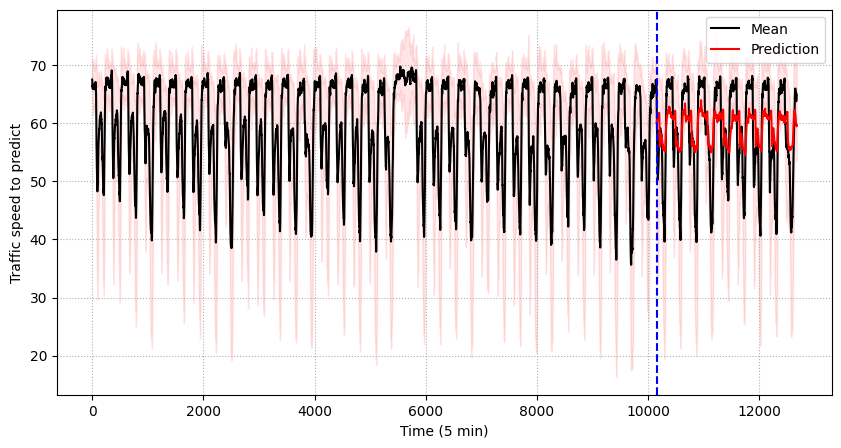

In [20]:
#Plotting the predictions against the original graph
y_preds = [inverse_zscore(model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy(), speeds.mean(axis=0), speeds.std(axis=0)).mean() for snapshot in test_dataset]

mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5))
plt.plot(np.array(mean), 'k-', label='Mean')
plt.plot(range(len(speeds)-len(y_preds), len(speeds)), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.axvline(x=len(speeds)-len(y_preds), color='b', linestyle='--')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')